In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-09-03 02:51:11.835147: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 02:51:11.835190: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 02:51:11.835219: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 02:51:11.844181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


# Datos

In [2]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/data/Materiales/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[5]
    number = ruta_list[6]
    tipo = ruta_list[7]
    name = ruta_list[8].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1,random_state=42)

print('Imágenes:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes: 923
MF1: 378
MF2: 284
MF3: 261


/tmp/ipykernel_59832/763690711.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  routes_dataset['label'].replace(char_to_num,inplace=True)


,name,route_image,label,number,route_mask
324,IMG_20230707_180522_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,5,/data/Materiales/Micrografías segmentaciones/s...
867,IMG_20230711_214815_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,6,/data/Materiales/Micrografías segmentaciones/s...
31,IMG_20230602_210322_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,3,/data/Materiales/Micrografías segmentaciones/s...
843,IMG_20230711_212848_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,7,/data/Materiales/Micrografías segmentaciones/s...
295,IMG_20230707_174047_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,4,/data/Materiales/Micrografías segmentaciones/s...
...,...,...,...,...,...
107,IMG_20230707_161853_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,1,/data/Materiales/Micrografías segmentaciones/s...
271,IMG_20230707_173655_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,4,/data/Materiales/Micrografías segmentaciones/s...
866,IMG_20230711_214812_jpg,/data/Materiales/Micrografías segmentaciones/s...,2,6,/data/Materiales/Micrografías segmentaciones/s...
436,IMG_20230707_191401_jpg,/data/Materiales/Micrografías segmentaciones/s...,0,7,/data/Materiales/Micrografías segmentaciones/s...


In [3]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [5]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')           

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter), npores]
        
        descriptors.append(descriptor)
        
    
    return descriptors

def create_dataset(buffer,file_names, labels, file_mask): 
  ## Get binary images   
  masks = get_binary_image(file_mask)
  ## Get geometric atributes from binary images
  attributes = get_geometric_atributes(masks)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

### Dataset entrenamiento
file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
## Create training dataset using tf.data of 16 images
dataset = create_dataset(16,file_names, labels,file_mask)

### Dataset test
file_names = test_df['route_image'].to_numpy()
file_mask = test_df['route_mask'].to_numpy()
labels = test_df['label'].to_numpy()
## Create test dataset using tf.data of 16 images
dataset_test = create_dataset(16,file_names, labels,file_mask) 

[174.28571429  52.56215173  13.65660088  35.        ]
0


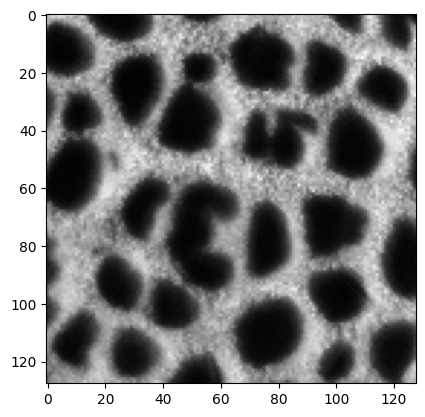

In [6]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]
    #d = i[3]

n =  0
print(c[n].numpy())
#imprimir solo el valor numérico del tensor sin la b
print(int(b[n].numpy()))
plt.imshow(a[n],cmap='gray')
#plt.imshow(d[n],cmap='gray')
plt.show()

In [8]:
## Crear np.array con las imágenes y sus features
# Test
X_test = []
y_test_class = []
y_test_mean_pore_area = []
y_test_mean_pore_pmtr = []
y_test_mean_pore_eq_diameter = []
y_test_n_pores = []

for i in dataset_test:
    ## cargar imágenes para introducir al modelo
    X_test.append(i[0].numpy())
    y_test_class.append(int(i[1].numpy()))
    ## extraer propiedades una a una 
    y_test_mean_pore_area.append(i[2][0].numpy())
    y_test_mean_pore_pmtr.append(i[2][1].numpy())
    y_test_mean_pore_eq_diameter.append(i[2][2].numpy())
    y_test_n_pores.append(i[2][3].numpy())
    

X_test = np.array(X_test).astype(np.float32)
y_test_class = np.array(y_test_class)
y_test_mean_pore_area = np.array(y_test_mean_pore_area)
y_test_mean_pore_pmtr = np.array(y_test_mean_pore_pmtr)
y_test_mean_pore_eq_diameter = np.array(y_test_mean_pore_eq_diameter)
y_test_n_pores = np.array(y_test_n_pores)

# Train
X_train = []
y_train_class = []
y_train_mean_pore_area = []
y_train_mean_pore_pmtr = []
y_train_mean_pore_eq_diameter = []
y_train_n_pores = []


for i in dataset:
    X_train.append(i[0].numpy())
    y_train_class.append(str(int(i[1].numpy())))
    ## extraer propiedades una a una 
    y_train_mean_pore_area.append(i[2][0].numpy())
    y_train_mean_pore_pmtr.append(i[2][1].numpy())
    y_train_mean_pore_eq_diameter.append(i[2][2].numpy())
    y_train_n_pores.append(i[2][3].numpy())

X_train = np.array(X_train).astype(np.float32)
y_train_class = np.array(y_train_class)
y_train_mean_pore_area = np.array(y_train_mean_pore_area)
y_train_mean_pore_pmtr = np.array(y_train_mean_pore_pmtr)
y_train_mean_pore_eq_diameter = np.array(y_train_mean_pore_eq_diameter)
y_train_n_pores = np.array(y_train_n_pores)

    
print(np.shape(X_train))    

(740, 128, 128, 1)


# Modelo

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
encoder = keras.models.load_model('Models2/weakly_disc_deep_GVAE_encoder_DRY_2_16.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models2/weakly_disc_deep_GVAE_decoder_DRY_2_16.h5', custom_objects={'Sampling':Sampling})

# Properties over latent space

## Generar embebidos

In [11]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 8
dmy = 4

In [12]:
## Data train and test
data_train = X_train
data_test = X_test

## Labels
label_train = y_train_class
label_test = y_test_class

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-09-03 02:55:08.313720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


24/24 [==============================] - 2s 10ms/step
Shape_embs:  (3, 740, 16)
6/6 [==============================] - 0s 28ms/step
Shape_embs:  (3, 183, 16)


### PCA

In [13]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(183, 2)

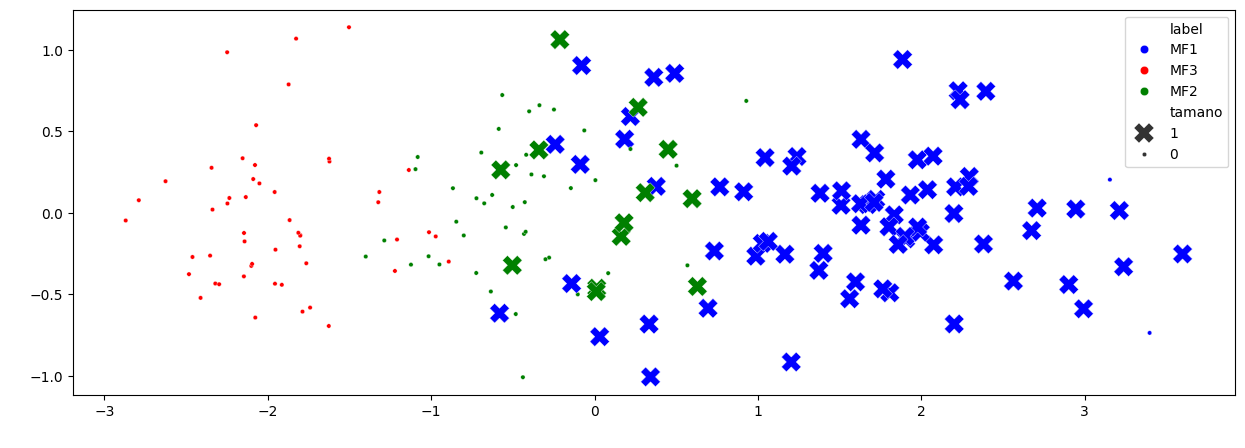

In [14]:
## graph pca embbedings regarding labels
labels_text_test = pd.DataFrame(label_test).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text_test.shape

data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)
data_img_pca_test['area'] = y_test_mean_pore_area
data_img_pca_test['perimetro'] = y_test_mean_pore_pmtr
data_img_pca_test['eq_diameter'] = y_test_mean_pore_eq_diameter
data_img_pca_test['poros'] = y_test_n_pores

## crear una columna que categorice los poros por tamaño de 1 a 5
data_img_pca_test['tamano'] = data_img_pca_test['area'].apply(lambda x: 1 if x > np.mean(y_test_mean_pore_area) else 0)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,
                style='tamano',
                alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True, size='tamano',sizes=(10, 200),size_order=[1,0])
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

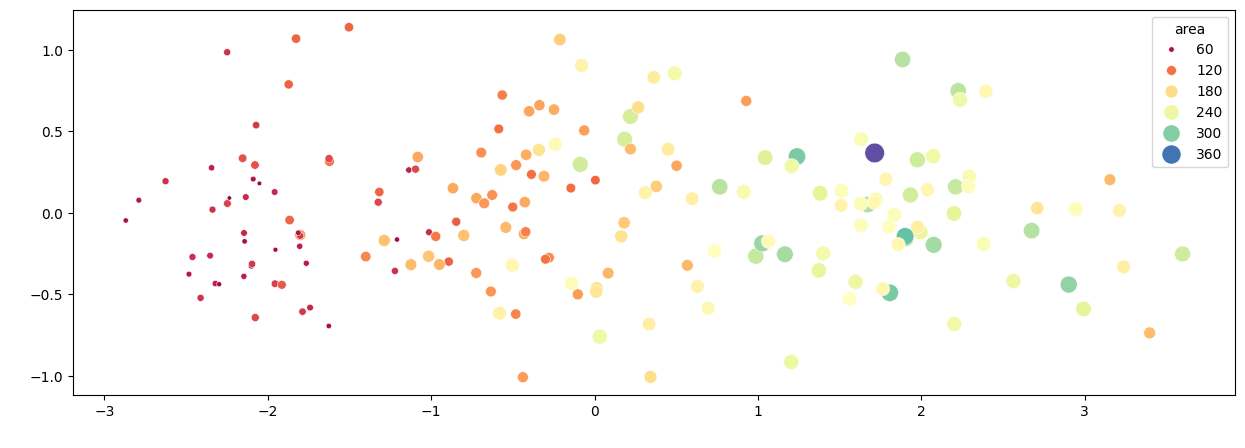

In [15]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='area',data=data_img_pca_test, 
                alpha=1, palette= "Spectral",size='area',sizes=(10, 200),size_order=[1,0])

## Set colobar
#data_color = pore_area_test
#min = np.min(data_color)
#max = np.max(data_color)
#plt.colorbar(cm.ScalarMappable(cmap=plt.jet()),label='Pore area',orientation='vertical', ax=plt.gca())

plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()


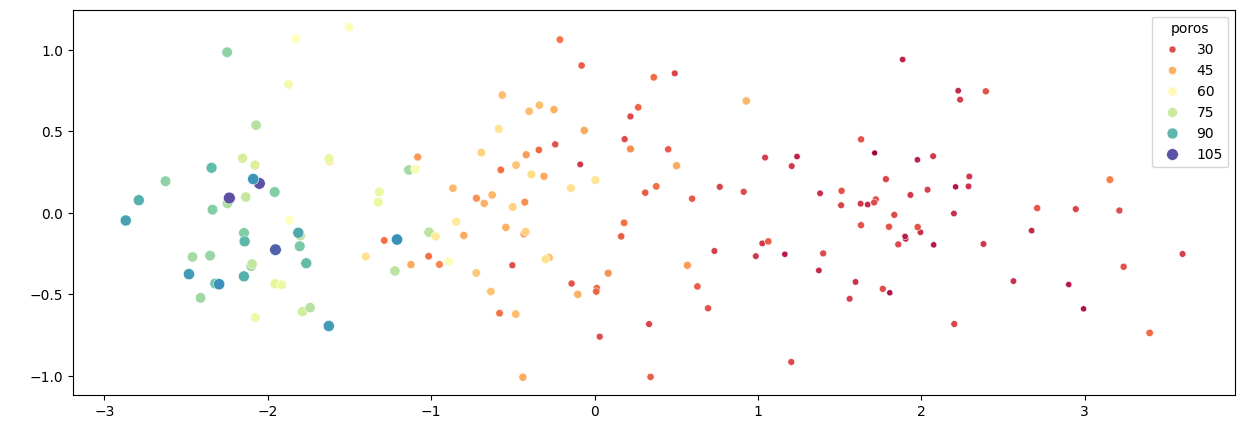

In [16]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='poros',data=data_img_pca_test, 
                alpha=1, palette="Spectral",size='poros')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

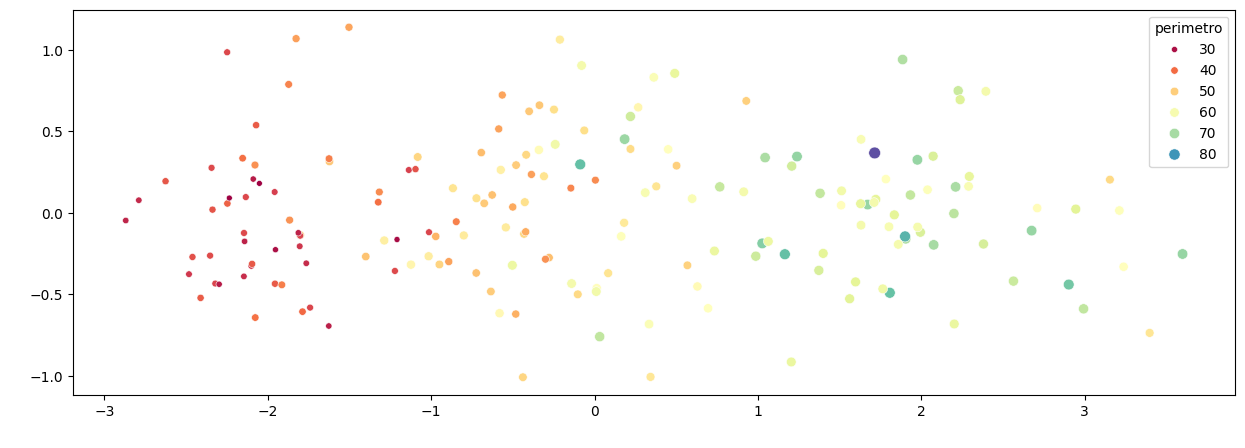

In [17]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='perimetro',data=data_img_pca_test, 
                alpha=1, palette="Spectral",size='perimetro')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

## Validación estadística de las propiedades de poro

In [19]:
## cargar regresor
regressor = keras.models.load_model('Models2/weakly_disc_deep_GVAE_regressor_DRY_2_16.h5')

In [20]:
## capturar embeddings de test and pore properties
embs = encoder_embds_test[D]
poros = y_test_n_pores
areas = y_test_mean_pore_area
perimetros = y_test_mean_pore_pmtr
diametros = y_test_mean_pore_eq_diameter

## generar reconstrucciones con embs
reconstructions = decoder.predict(embs)

## generar propiedades de los poros from reconstructions
predicted_features = regressor.predict(reconstructions)

## calcular diferencias MSE, RMSE, MAE

predicted_features = np.squeeze(regressor.predict(reconstructions))

## metrics for pore area (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(areas,predicted_features[0,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(areas,predicted_features[0,:])
l1 = tf.keras.losses.mean_absolute_error(areas,predicted_features[0,:])
print("Pore area") 
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())


## metrics for pore perimeter (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(perimetros,predicted_features[1,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(perimetros,predicted_features[1,:])
l1 = tf.keras.losses.mean_absolute_error(perimetros,predicted_features[1,:])

print("Pore perimeter")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())

## metrics for pore equivalent diameter (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(diametros,predicted_features[2,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(diametros,predicted_features[2,:])
l1 = tf.keras.losses.mean_absolute_error(diametros,predicted_features[2,:])

print("Pore equivalent diameter")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())

## metrics for pore number (MSE, RMSE, MAE, L1)
mse = tf.keras.losses.mean_squared_error(poros,predicted_features[3,:])
rmse = tf.math.sqrt(mse)
mae = tf.keras.losses.mean_absolute_error(poros,predicted_features[3,:])
l1 = tf.keras.losses.mean_absolute_error(poros,predicted_features[3,:])

print("Pore number")
print('MSE: ',mse.numpy())
print('RMSE: ',rmse.numpy())
print('MAE: ',mae.numpy())
print('L1: ',l1.numpy())



6/6 [==============================] - 0s 4ms/step
Pore area
MSE:  14035.257
RMSE:  118.47049
MAE:  100.8955
L1:  100.8955
Pore perimeter
MSE:  195.00262
RMSE:  13.964334
MAE:  12.627021
L1:  12.627021
Pore equivalent diameter
MSE:  2727.4485
RMSE:  52.22498
MAE:  51.62945
L1:  51.62945
Pore number
MSE:  1355.8378
RMSE:  36.8217
MAE:  33.04112
L1:  33.04112
